In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Fixed import section - removed duplicates and organized properly
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import seaborn as sns
from time import perf_counter
import shutil
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import logging
import time
from pathlib import Path
from tensorflow.keras import layers, models
import cv2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from collections import Counter


# Configure logging
logging.basicConfig(level=logging.INFO, 
                   format='%(asctime)s - %(levelname)s - %(message)s',
                   datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
file_handler = logging.FileHandler('dr_training.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(file_handler)

import warnings
warnings.filterwarnings('ignore')
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return tf.keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform")

# Enable mixed precision for faster training on compatible GPUs
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled")
except:
    print("Mixed precision not available")
def oversample_dataframe(df, label_col='label_idx'):
    """
    Oversample minority classes in a dataframe to match the size of the largest class.
    Useful for imbalanced classification tasks.
    """
    from sklearn.utils import resample

    max_size = df[label_col].value_counts().max()
    dfs = []

    for class_idx in df[label_col].unique():
        df_class = df[df[label_col] == class_idx]
        df_upsampled = resample(df_class,
                                replace=True,
                                n_samples=max_size,
                                random_state=42)
        dfs.append(df_upsampled)

    df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    return df_balanced

# Add the custom MobileNetV2DR architecture
def preprocess_input(x):
    """Enhanced preprocessing for fundus images with better normalization."""
    # Convert to float32
    x = tf.cast(x, tf.float32)
    
    # Normalize to [0, 1] range
    x = x / 255.0
    
    # Apply mild gamma correction for better contrast
    x = tf.pow(x, 0.9)
    
    # Center around 0 with proper scaling
    x = (x - 0.5) * 2.0
    
    return x

def _make_divisible(v, divisor, min_value=None):
    """Ensures that all layers have channels numbers divisible by 8."""
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, use_se=False):
    """Inverted ResNet block with optional squeeze and excitation."""
    channel_axis = -1  # For channels_last format
    
    in_channels = tf.keras.backend.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = f'block_{block_id}_'

    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        padding = 'valid'
        x = layers.ZeroPadding2D(
            padding=((0, 1), (0, 1)),
            name=prefix + 'pad')(x)
    else:
        padding = 'same'
        
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               use_bias=False,
                               padding=padding,
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'depthwise_BN')(x)
    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Add squeeze and excitation block for retina images
    if use_se:
        squeeze = layers.GlobalAveragePooling2D()(x)
        squeeze = layers.Dense(max(1, int(in_channels * expansion / 4)),
                             activation='relu')(squeeze)
        squeeze = layers.Dense(int(in_channels * expansion),
                             activation='sigmoid')(squeeze)
        squeeze = layers.Reshape((1, 1, int(in_channels * expansion)))(squeeze)
        x = layers.multiply([x, squeeze])

    # Project
    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

def MobileNetV2DR(input_shape=(224, 224, 3),
                alpha=1.0,
                include_top=True,
                weights=None,
                input_tensor=None,
                pooling=None,
                dropout_rate=0.3,
                classes=5,
                use_se=True):
    
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = -1  # TF uses channels last format

    # Apply color normalization specific to fundus images
    # This helps in enhancing blood vessels and lesions
    x = img_input
    
    # Build network
    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='same',
                      use_bias=False,
                      name='Conv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, use_se=use_se)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, use_se=use_se)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, use_se=use_se)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, use_se=use_se)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, use_se=use_se)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, use_se=use_se)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6, use_se=use_se)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7, use_se=use_se)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8, use_se=use_se)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9, use_se=use_se)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10, use_se=use_se)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11, use_se=use_se)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12, use_se=use_se)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13, use_se=use_se)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14, use_se=use_se)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15, use_se=use_se)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16, use_se=use_se)

    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        # Global pooling
        x = layers.GlobalAveragePooling2D()(x)

        x = layers.BatchNormalization()(x)
        
        # Add dropout for better regularization - important for medical imaging

        x = layers.Dense(256, 
                        activation='relu',
                        kernel_initializer='he_normal',
                        kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

        x = layers.Dense(128, 
                        activation='relu',
                        kernel_initializer='he_normal',
                        kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate * 0.5)(x)
        
        # Dense layer with activation suited for multi-class classification
        x = layers.Dense(classes, 
                        kernel_initializer=tf.keras.initializers.GlorotUniform(),
                        kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        # For binary DR detection (DR vs No DR)
        if classes == 2:
            x = layers.Activation('sigmoid', name='Predictions')(x)
        # For multi-class DR grading (0-4 severity levels)
        else:
            x = layers.Activation('softmax', name='Predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    model = models.Model(img_input, x, name=f'mobilenetv2_dr_{alpha:.2f}')
    
    return model
# Dataset distribution analysis
def count_images_in_folder(folder_path):
    """Count images in a folder with improved efficiency."""
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
    image_count = 0
    folder_name = os.path.basename(folder_path)
    
    print(f"Counting images in {folder_name}...")
    logger.info(f"Counting images in {folder_name}...")
    
    path_obj = Path(folder_path)
    all_files = list(path_obj.glob('**/*'))
    total_files = len(all_files)
    
    for i, file_path in enumerate(all_files):
        if file_path.suffix.lower() in image_extensions:
            image_count += 1
        
        if i % max(int(total_files * 0.05), 1000) == 0 and i > 0:
            progress_msg = f"Processed {i}/{total_files} files ({i/total_files*100:.1f}%) in {folder_name}"
            print(progress_msg)
            logger.info(progress_msg)
    
    result_msg = f"Found {image_count} images in {folder_name}"
    print(result_msg)
    logger.info(result_msg)
    return image_count

# FIXED: Updated paths to be more generic (you'll need to adjust these to your actual paths)
print("Analyzing dataset distribution...")
base_path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images"  # Update this path
no_dr_images = count_images_in_folder(f'{base_path}/No_DR')
mild_images = count_images_in_folder(f'{base_path}/Mild')
moderate_images = count_images_in_folder(f'{base_path}/Moderate')
severe_images = count_images_in_folder(f'{base_path}/Severe')
proliferate_images = count_images_in_folder(f'{base_path}/Proliferate_DR')

# Enhanced class balancing with multiple strategies
def calculate_advanced_class_weights(class_counts, strategy='focal', alpha=0.25, gamma=2.0, beta=0.9999):
    """
    Calculate class weights using different strategies for imbalanced datasets.
    
    Args:
        class_counts: List of counts for each class
        strategy: 'balanced', 'focal', 'effective_number', 'sqrt', 'log'
        alpha: Focal loss alpha parameter
        gamma: Focal loss gamma parameter  
        beta: Effective number of samples parameter
    
    Returns:
        Dictionary of class weights
    """
    total_samples = sum(class_counts)
    n_classes = len(class_counts)
    
    if strategy == 'balanced':
        # Standard sklearn balanced approach
        weights = [total_samples / (n_classes * count) for count in class_counts]
    
    elif strategy == 'focal':
        # Focal loss inspired weighting - emphasizes hard examples
        frequencies = [count / total_samples for count in class_counts]
        weights = [alpha * (1 - freq) ** gamma for freq in frequencies]
    
    elif strategy == 'effective_number':
        # Effective Number of Samples (ENS) - handles extreme imbalance better
        effective_nums = [(1 - beta ** count) / (1 - beta) for count in class_counts]
        weights = [total_samples / effective_num for effective_num in effective_nums]
        # Normalize weights
        weight_sum = sum(weights)
        weights = [w / weight_sum * n_classes for w in weights]
    
    elif strategy == 'sqrt':
        # Square root balancing - gentler than inverse frequency
        weights = [np.sqrt(total_samples / count) for count in class_counts]
    
    elif strategy == 'log':
        # Logarithmic balancing - even gentler approach
        weights = [np.log(total_samples / count + 1) for count in class_counts]
    
    else:
        raise ValueError(f"Unknown strategy: {strategy}")
    
    # Convert to dictionary format
    class_weights = {i: weight for i, weight in enumerate(weights)}
    
    return class_weights

def analyze_class_imbalance(class_counts, class_names):
    """Analyze and visualize class imbalance."""
    total_samples = sum(class_counts)
    
    print("\n" + "="*60)
    print("CLASS IMBALANCE ANALYSIS")
    print("="*60)
    
    # Calculate imbalance metrics
    imbalance_ratios = []
    for i, count in enumerate(class_counts):
        ratio = max(class_counts) / count
        percentage = (count / total_samples) * 100
        print(f"{class_names[i]:15} | Count: {count:6d} | {percentage:5.1f}% | IR: {ratio:5.1f}x")
        imbalance_ratios.append(ratio)
    
    max_ir = max(imbalance_ratios)
    print(f"\nMaximum Imbalance Ratio: {max_ir:.1f}x")
    
    # Categorize imbalance severity
    if max_ir < 2:
        severity = "BALANCED"
    elif max_ir < 10:
        severity = "MODERATELY IMBALANCED"
    elif max_ir < 100:
        severity = "HIGHLY IMBALANCED"
    else:
        severity = "EXTREMELY IMBALANCED"
    
    print(f"Dataset Imbalance Severity: {severity}")
    
    return max_ir, severity

def compare_weighting_strategies(class_counts, class_names):
    """Compare different class weighting strategies."""
    strategies = ['balanced', 'focal', 'effective_number', 'sqrt', 'log']
    
    print("\n" + "="*80)
    print("CLASS WEIGHT COMPARISON")
    print("="*80)
    print(f"{'Class':<15} {'Balanced':<10} {'Focal':<10} {'EffNum':<10} {'Sqrt':<10} {'Log':<10}")
    print("-" * 80)
    
    strategy_weights = {}
    for strategy in strategies:
        strategy_weights[strategy] = calculate_advanced_class_weights(class_counts, strategy=strategy)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15}", end=" ")
        for strategy in strategies:
            weight = strategy_weights[strategy][i]
            print(f"{weight:<10.3f}", end=" ")
        print()
    
    return strategy_weights

# Replace the existing class weight calculation section with this:
print("\nAnalyzing class imbalance...")
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
label_to_idx = {'No_DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferate_DR': 4}
idx_to_label = {v: k for k, v in label_to_idx.items()}  # Optional: reverse mapping

class_counts = [no_dr_images, mild_images, moderate_images, severe_images, proliferate_images]

# Analyze imbalance
max_ir, severity = analyze_class_imbalance(class_counts, class_names)

# Compare different weighting strategies
strategy_weights = compare_weighting_strategies(class_counts, class_names)

# Choose the best strategy based on imbalance severity
if max_ir < 10:
    chosen_strategy = 'sqrt'  # Gentler for moderate imbalance
elif max_ir < 100:
    chosen_strategy = 'focal'  # Good for high imbalance
else:
    chosen_strategy = 'effective_number'  # Best for extreme imbalance

class_weights = calculate_advanced_class_weights(class_counts, strategy=chosen_strategy)

print(f"\nChosen strategy: {chosen_strategy.upper()}")
print("Final class weights:")
for cls, weight in class_weights.items():
    print(f"Class {cls} ({class_names[cls]}): {weight:.4f}")

# Visualize class weights comparison
plt.figure(figsize=(15, 8))

# Plot 1: Class distribution
plt.subplot(2, 2, 1)
plt.bar(class_names, class_counts, color='skyblue', alpha=0.7)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')

# Plot 2: Imbalance ratios
plt.subplot(2, 2, 2)
max_count = max(class_counts)
imbalance_ratios = [max_count / count for count in class_counts]
plt.bar(class_names, imbalance_ratios, color='coral', alpha=0.7)
plt.title('Imbalance Ratios')
plt.xticks(rotation=45)
plt.ylabel('Imbalance Ratio (times)')

# Plot 3: Weight comparison
plt.subplot(2, 2, 3)
strategies = ['balanced', 'focal', 'sqrt']
x = np.arange(len(class_names))
width = 0.25

for i, strategy in enumerate(strategies):
    weights = [strategy_weights[strategy][j] for j in range(len(class_names))]
    plt.bar(x + i*width, weights, width, label=strategy, alpha=0.7)

plt.title('Class Weights Comparison')
plt.xlabel('Classes')
plt.ylabel('Weight')
plt.xticks(x + width, class_names, rotation=45)
plt.legend()

# Plot 4: Chosen weights
plt.subplot(2, 2, 4)
final_weights = [class_weights[i] for i in range(len(class_names))]
plt.bar(class_names, final_weights, color='green', alpha=0.7)
plt.title(f'Final Weights ({chosen_strategy})')
plt.xticks(rotation=45)
plt.ylabel('Weight')

plt.tight_layout()
plt.savefig('class_balancing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
# Create image dataset
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
# Validate all labels are mapped
unmapped_labels = set(labels.unique()) - set(label_to_idx.keys())
if unmapped_labels:
    raise ValueError(f"Unmapped labels found: {unmapped_labels}")

numeric_labels = labels.map(label_to_idx)


image_df = pd.concat([filepaths, labels, numeric_labels.rename('label_idx')], axis=1)
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Mapped labels:")
print(image_df[['Label', 'label_idx']].drop_duplicates())


print("\nDataset preview:")
print(image_df.head(3))

# Visualization functions
def visualize_dataset():
    """Visualize sample images and class distribution."""
    # Display sample images
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        if i < len(image_df):
            ax.imshow(plt.imread(image_df.Filepath[i]))
            ax.set_title(image_df.Label[i])
    plt.tight_layout()
    plt.show()

    # Display class distribution
    vc = image_df['Label'].value_counts()
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=vc.index, y=vc, palette="rocket")
    plt.title("Number of pictures of each category", fontsize=15)
    for i, count in enumerate(vc.values):
        ax.text(i, count + 5, str(count), ha='center', fontsize=10, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Stratified data splitting
def create_stratified_splits(df, n_splits=3, test_size=0.15):
    """Create stratified k-fold splits with validation and test sets."""
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, stratify=df['label_idx'], random_state=42
    )
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_dfs = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_df, train_val_df['label_idx'])):
        train_df = train_val_df.iloc[train_idx].reset_index(drop=True)
        val_df = train_val_df.iloc[val_idx].reset_index(drop=True)
        fold_dfs.append((fold, train_df, val_df))
    
    return fold_dfs, test_df

# Create data generators
def create_gen():
    """Create data generators with appropriate augmentation."""
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input,
         rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode="nearest"
        # cval=0
    )
    
    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rescale=None
    )
    
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    
    return train_generator, val_generator, test_generator

def create_data_generators(train_df, val_df, test_df, batch_size=16):
    """Create data generators for training, validation, and testing."""
    train_generator, val_generator, test_generator = create_gen()
    
    # Force consistent class order
    class_order = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
    
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',                  # column with string labels
        classes=class_order,            # 🔥 fixes label-to-index mapping
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',       # 🔥 returns one-hot vectors
        batch_size=batch_size,
        shuffle=True,
        interpolation='bilinear',
        validate_filenames=True,  
        seed=42
    )
    
    val_images = val_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='Filepath',
        y_col='Label',
        classes=class_order,            # 🔥 keep same mapping
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        validate_filenames=True,
        seed=42
    )
    
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        classes=class_order,            # 🔥 again for consistency
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size * 2,
        shuffle=False,
        validate_filenames=True
    )

    return train_images, val_images, test_images



# FIXED: Create the missing model creation function
def create_dr_model(input_shape=(224, 224, 3), classes=5, weights=None, dropout_rate=0.4):
    """Create a custom MobileNetV2DR model for diabetic retinopathy classification."""
    
    # Create the custom MobileNetV2DR model
    model = MobileNetV2DR(
        input_shape=input_shape,
        alpha=1.0,
        include_top=True,
        weights=None,  # We'll use custom weights or train from scratch
        pooling=None,
        dropout_rate=dropout_rate,
        classes=classes,
        use_se=True  # Enable squeeze-excitation for better feature extraction
    )
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0005,  # Lower learning rate
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    # Compile model with appropriate metrics for multi-class classification
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.1),
        metrics=[
                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.AUC(name='auc',multi_label=False),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model
def create_lr_scheduler():
    """Create a learning rate scheduler that logs learning rate."""
    def scheduler(epoch, lr):
        new_lr = lr
        if epoch < 3:
            new_lr = lr
        elif epoch < 15:
            new_lr = lr * 0.7
        else:
            new_lr = lr * 0.1
        
        print(f"Epoch {epoch}: Learning rate set to {new_lr}")
        return new_lr
    
    return tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# FIXED: Simplified logging callback
class LoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs
        self.epoch_start_time = None
    
    def on_train_begin(self, logs=None):
        print(f"Starting training for {self.total_epochs} epochs")
        logger.info(f"Starting training for {self.total_epochs} epochs")
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"Epoch {epoch + 1}/{self.total_epochs} beginning")
        logger.info(f"Epoch {epoch + 1}/{self.total_epochs} beginning")
    
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        if logs:
            metrics_str = ' - '.join([f"{k}: {v:.4f}" for k, v in logs.items()])
            message = f"Epoch {epoch + 1}/{self.total_epochs} completed: {metrics_str} - {epoch_time:.2f}s"
            print(message)
            logger.info(message)
    
    def on_train_end(self, logs=None):
        print("Training completed")
        logger.info("Training completed")

def get_callbacks(fold, patience=15, total_epochs=20):
    """Get callbacks for training."""
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f'best_model_fold_{fold}.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    # Add LearningRateScheduler to track learning rate
    lr_scheduler = create_lr_scheduler()
    
    logging_callback = LoggingCallback(total_epochs=total_epochs)
    
    csv_logger = tf.keras.callbacks.CSVLogger(
        f'training_fold_{fold}.log',
        separator=',',
        append=False
    )
    
    return [checkpoint, early_stopping, reduce_lr, lr_scheduler, logging_callback, csv_logger]

# FIXED: Simplified confusion matrix callback
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, class_names):
        super(ConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Compute confusion matrix every 5 epochs
            try:
                # Get predictions
                y_pred = np.argmax(self.model.predict(self.validation_data, verbose=0), axis=1)
                y_true = self.validation_data.classes
                
                # Compute confusion matrix
                cm = confusion_matrix(y_true, y_pred)

                misclass = [(true, pred) for true, pred in zip(y_true, y_pred) if true != pred]
                top_misclass = Counter(misclass).most_common(3)

                print(f"[Epoch {epoch}] Top misclassifications:")
                for (true_label, pred_label), count in top_misclass:
                    print(f"  {self.class_names[true_label]} → {self.class_names[pred_label]}: {count} times")
                
                # Plot confusion matrix
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                           xticklabels=self.class_names, 
                           yticklabels=self.class_names)
                plt.title(f'Confusion Matrix - Epoch {epoch}')
                plt.ylabel('True Label')
                plt.xlabel('Predicted Label')
                plt.tight_layout()
                plt.savefig(f'confusion_matrix_epoch_{epoch}.png')
                plt.close()
            except Exception as e:
                print(f"Error generating confusion matrix on epoch {epoch}: {e}")

# Model evaluation functions
def evaluate_model(model, test_generator, class_names):
    """Evaluate model performance with detailed metrics and visualizations."""
    y_pred_probs = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_final.png')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Compute ROC AUC for multi-class
    n_classes = len(class_names)
    
    # One-hot encode true labels
    lb = LabelBinarizer()
    lb.fit(range(n_classes))
    y_true_bin = lb.transform(y_true)
    
    # Plot ROC curves for each class
    plt.figure(figsize=(12, 10))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'classification_report': classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    }

# Cross-validation function
def run_cross_validation(fold_dfs, test_df, epochs=20, batch_size=16):
    """Run k-fold cross-validation training and evaluation."""
    results = []
    fold_histories = []
    

    for fold, train_df, val_df in fold_dfs:
        logger.info(f"{'='*50}")
        logger.info(f"Training Fold {fold+1}")
        logger.info(f"{'='*50}")
        
        # Get callbacks - FIXED: Use the updated get_callbacks function
        callbacks = get_callbacks(fold=fold, patience=12, total_epochs=epochs)
        
        # Add terminate on NaN callback
        callbacks.append(tf.keras.callbacks.TerminateOnNaN())

        print(f"Oversampling training data for Fold {fold + 1}...")
        train_df = oversample_dataframe(train_df, label_col='label_idx')
        
        # Create data generators
        train_gen, val_gen, _ = create_data_generators(train_df, val_df, test_df, batch_size=batch_size)
        
        label_to_idx = train_gen.class_indices
        class_names = list(label_to_idx.keys())

        print("DEBUG: Generator class indices:", train_gen.class_indices)
        print("DEBUG: Label to index mapping:", label_to_idx)

        print(f"\n[Fold {fold+1}] Validation label distribution:")
        print(val_df['label_idx'].value_counts(normalize=True).sort_index())
        # Create model
        model = create_dr_model(input_shape=(224, 224, 3), classes=5, weights=None)
        
        # Add confusion matrix callback
        cm_callback = ConfusionMatrixCallback(val_gen, class_names)
        callbacks.append(cm_callback)
        
        # Prepare class weights
        # Use actual mapping from the training generator
        train_class_indices = train_gen.class_indices
        class_idx_weights = {v: class_weights.get(v, 1.0) for k, v in train_class_indices.items()}
        for i in range(5):  # assuming 5 classes (0-4)
            if i not in class_idx_weights:
                print(f"⚠️  WARNING: Class {i} missing from class_idx_weights! Defaulting to 1.0")
                class_idx_weights[i] = 1.0

        print(f"[Fold {fold+1}] Final class weights used in training: {class_idx_weights}")

        
        start = time.time()
        
        # Train the model
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_idx_weights,
            verbose=1
        )
        
        duration = time.time() - start
        logger.info(f"Fold {fold+1} trained in {duration:.2f} seconds")

        val_preds = model.predict(val_gen, verbose=1)
        val_pred_labels = np.argmax(val_preds, axis=1)
        true_labels = val_gen.classes

        print(f"DEBUG: Fold {fold+1}")
        print("DEBUG: Unique predicted labels:", np.unique(val_pred_labels))
        print("DEBUG: Distribution of predictions:", np.bincount(val_pred_labels))
        
        # Save model
        model.save(f'model_fold_{fold+1}.h5')
        
        # Store results
        fold_histories.append(history.history)
        
        # FIXED: Handle missing 'lr' key with error handling
        try:
            final_lr = float(history.history['lr'][-1]) if 'lr' in history.history else model.optimizer.learning_rate.numpy()
        except (KeyError, AttributeError):
            final_lr = model.optimizer.learning_rate.numpy() if hasattr(model.optimizer.learning_rate, 'numpy') else float(model.optimizer.learning_rate)
        
        val_metrics = {
            'fold': fold + 1,
            'val_accuracy': history.history['val_accuracy'][-1],
            'val_loss': history.history['val_loss'][-1],
            'val_auc': history.history['val_auc'][-1],
            'val_precision': history.history['val_precision'][-1],
            'val_recall': history.history['val_recall'][-1],
            'final_lr': final_lr,  # FIXED: Use the safely retrieved learning rate
            'training_time': duration
        }
        
        results.append(val_metrics)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Display average metrics
    logger.info("\nCross-Validation Results:")
    logger.info("=" * 50)
    logger.info(f"Average Validation Accuracy: {results_df['val_accuracy'].mean():.4f} ± {results_df['val_accuracy'].std():.4f}")
    logger.info(f"Average Validation AUC: {results_df['val_auc'].mean():.4f} ± {results_df['val_auc'].std():.4f}")
    logger.info(f"Average Validation Precision: {results_df['val_precision'].mean():.4f} ± {results_df['val_precision'].std():.4f}")
    logger.info(f"Average Validation Recall: {results_df['val_recall'].mean():.4f} ± {results_df['val_recall'].std():.4f}")
    
    return results_df, fold_histories

# Main execution
if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    logger.info("Starting diabetic retinopathy classification pipeline...")
    
    # Create stratified splits
    print("\nCreating stratified dataset splits...")
    fold_dfs, test_df = create_stratified_splits(image_df, n_splits=3)
    
    # Print split statistics
    for fold, train_df, val_df in fold_dfs:
        print(f"\nFold {fold+1}:")
        print(f"  Train set: {len(train_df)} images")
        print(f"  Validation set: {len(val_df)} images")
    
    print(f"\nTest set: {len(test_df)} images")
    
    # Visualize dataset
    visualize_dataset()
    
    # Run cross-validation
    logger.info("Running cross-validation...")
    cv_results, fold_histories = run_cross_validation(fold_dfs, test_df, epochs=30, batch_size=16)
    
    print("\nCross-validation completed!")
    print(cv_results)
    
    logger.info("Pipeline completed successfully!")

In [4]:
pip install -U scikit-learn imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 104.3 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import os
import cv2
from glob import glob
import albumentations as A
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

class Config:
    """Configuration class for hyperparameters"""
    IMG_SIZE = 224
    BATCH_SIZE = 32  # Increased batch size for stability
    EPOCHS = 100     # Increased epochs for better convergence
    LEARNING_RATE = 0.001  # Higher initial LR with better scheduling
    PATIENCE = 25    # Increased patience
    MIN_LR = 1e-8
    WEIGHT_DECAY = 1e-4  # L2 regularization
    
    # Class names
    CLASS_NAMES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
    NUM_CLASSES = len(CLASS_NAMES)
    
    # Dataset paths
    DATA_PATH = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
    
    # Balancing parameters
    MIN_SAMPLES_PER_CLASS = 800
    MAX_SAMPLES_PER_CLASS = 2000

class AdvancedAugmentation:
    """Refined augmentation pipeline"""
    
    @staticmethod
    def get_train_augmentation():
        return A.Compose([
            # Geometric transformations
            A.HorizontalFlip(p=0.4),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=15, p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.05, 
                scale_limit=0.1, 
                rotate_limit=10, 
                p=0.5
            ),
            
            # Color and lighting adjustments
            A.RandomBrightnessContrast(
                brightness_limit=0.1, 
                contrast_limit=0.1, 
                p=0.5
            ),
            A.CLAHE(clip_limit=2.0, p=0.5),
            
            # Normalize
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    @staticmethod
    def get_val_augmentation():
        return A.Compose([
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

class RefinedFocalLoss(keras.losses.Loss):
    """Optimized Focal Loss with adaptive gamma"""
    
    def __init__(self, gamma=2.0, name='refined_focal_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.gamma = gamma
    
    def get_config(self):
        config = super().get_config()
        config.update({'gamma': self.gamma})
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        
        # Cross entropy
        ce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
        
        # Focal weight
        p_t = tf.reduce_sum(y_true * y_pred, axis=1)
        focal_weight = tf.pow(1 - p_t, self.gamma)
        
        focal_loss = focal_weight * ce
        
        return tf.reduce_mean(focal_loss)

def balance_dataset_improved(image_paths, labels):
    """Improved dataset balancing with stratification"""
    print("Balancing dataset with improved strategy...")
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    class_distribution = dict(zip(unique_labels, counts))
    
    print("Original class distribution:")
    for label, count in class_distribution.items():
        print(f"{Config.CLASS_NAMES[label]}: {count}")
    
    target_counts = np.clip(counts, Config.MIN_SAMPLES_PER_CLASS, Config.MAX_SAMPLES_PER_CLASS)
    
    balanced_paths = []
    balanced_labels = []
    
    for class_idx in range(Config.NUM_CLASSES):
        class_mask = labels == class_idx
        class_paths = image_paths[class_mask]
        class_labels = labels[class_mask]
        
        current_count = len(class_paths)
        target_count = target_counts[class_idx]
        
        if current_count < target_count:
            # Oversampling with augmentation
            oversampled_paths = []
            oversampled_labels = []
            
            for _ in range(target_count // current_count):
                oversampled_paths.extend(class_paths)
                oversampled_labels.extend(class_labels)
            
            # Add remaining samples
            remaining = target_count % current_count
            if remaining > 0:
                indices = np.random.choice(current_count, remaining, replace=False)
                oversampled_paths.extend(class_paths[indices])
                oversampled_labels.extend(class_labels[indices])
                
            balanced_paths.extend(oversampled_paths)
            balanced_labels.extend(oversampled_labels)
            
        elif current_count > target_count:
            # Undersampling
            indices = np.random.choice(current_count, target_count, replace=False)
            balanced_paths.extend(class_paths[indices])
            balanced_labels.extend(class_labels[indices])
        else:
            balanced_paths.extend(class_paths)
            balanced_labels.extend(class_labels)
    
    print("\nBalanced distribution:")
    balanced_unique, balanced_counts = np.unique(balanced_labels, return_counts=True)
    for label, count in zip(balanced_unique, balanced_counts):
        print(f"{Config.CLASS_NAMES[label]}: {count}")
    
    return np.array(balanced_paths), np.array(balanced_labels)

class EnhancedDataGenerator(keras.utils.Sequence):
    """Enhanced data generator with caching"""
    
    def __init__(self, image_paths, labels, batch_size, img_size, 
                 augmentation=None, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()
        
        # Pre-cache images
        self.image_cache = {}
        print(f"Caching {len(image_paths)} images...")
        for i, path in enumerate(image_paths):
            if i % 1000 == 0:
                print(f"Cached {i}/{len(image_paths)}")
            self.image_cache[path] = self._load_image(path)
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]
        
        X, y = self._generate_data(batch_paths, batch_labels)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def _load_image(self, path):
        try:
            image = cv2.imread(path)
            if image is None:
                return np.zeros((self.img_size, self.img_size, 3), dtype=np.float32)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            return cv2.resize(image, (self.img_size, self.img_size))
        except:
            return np.zeros((self.img_size, self.img_size, 3), dtype=np.float32)
    
    def _generate_data(self, batch_paths, batch_labels):
        X = np.empty((len(batch_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(batch_paths), Config.NUM_CLASSES), dtype=np.float32)
        
        for i, (path, label) in enumerate(zip(batch_paths, batch_labels)):
            image = self.image_cache[path].copy()
            
            # Apply augmentation
            if self.augmentation:
                augmented = self.augmentation(image=image)
                image = augmented['image']
            
            X[i] = image
            y[i] = keras.utils.to_categorical(label, Config.NUM_CLASSES)
        
        return X, y

def create_enhanced_model(input_shape, num_classes):
    """Enhanced CNN architecture with residual connections"""
    inputs = keras.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(64, 7, strides=2, padding='same', 
                     kernel_regularizer=regularizers.l2(Config.WEIGHT_DECAY))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual blocks
    def residual_block(x, filters, strides=1):
        shortcut = x
        
        x = layers.Conv2D(filters, 3, strides=strides, padding='same',
                         kernel_regularizer=regularizers.l2(Config.WEIGHT_DECAY))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        x = layers.Conv2D(filters, 3, padding='same',
                         kernel_regularizer=regularizers.l2(Config.WEIGHT_DECAY))(x)
        x = layers.BatchNormalization()(x)
        
        if strides > 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, strides=strides,
                                    kernel_regularizer=regularizers.l2(Config.WEIGHT_DECAY))(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.add([x, shortcut])
        x = layers.ReLU()(x)
        return x
    
    # Block sequence
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', 
                   kernel_regularizer=regularizers.l2(Config.WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

def create_advanced_callbacks(model_name='best_model.h5'):
    """Enhanced callbacks with learning rate warmup"""
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            model_name,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=Config.MIN_LR,
            verbose=1,
            cooldown=2
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=Config.PATIENCE,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        keras.callbacks.LearningRateScheduler(
            lambda epoch: Config.LEARNING_RATE * min(1.0, epoch / 10)  # Warmup
            if epoch < 15 else 
            Config.LEARNING_RATE * 0.5 * (1 + np.cos(np.pi * (epoch - 15) / (Config.EPOCHS - 15))),
            verbose=0
        )
    ]
    return callbacks

def compute_class_weights(labels):
    """Compute class weights based on effective samples"""
    class_counts = np.bincount(labels)
    total_samples = np.sum(class_counts)
    class_weights = total_samples / (Config.NUM_CLASSES * class_counts)
    class_weights = class_weights / np.max(class_weights)  # Normalize
    
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    print("\nClass weights:")
    for i, weight in class_weight_dict.items():
        print(f"{Config.CLASS_NAMES[i]}: {weight:.3f}")
    
    return class_weight_dict

def load_dataset(data_path):
    """Load dataset with improved validation split"""
    image_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(Config.CLASS_NAMES):
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            class_images = glob(os.path.join(class_path, '*'))
            image_paths.extend(class_images)
            labels.extend([class_idx] * len(class_images))
            print(f"Found {len(class_images)} images in {class_name}")
    
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    balanced_paths, balanced_labels = balance_dataset_improved(image_paths, labels)
    
    # Stratified split with multiple splits
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_index, val_index in sss.split(balanced_paths, balanced_labels):
        train_paths, val_paths = balanced_paths[train_index], balanced_paths[val_index]
        train_labels, val_labels = balanced_labels[train_index], balanced_labels[val_index]
    
    print(f"\nDataset split:")
    print(f"Training: {len(train_paths)}, Validation: {len(val_paths)}")
    
    return (train_paths, train_labels), (val_paths, val_labels)

def main():
    """Enhanced main training function"""
    print("Enhanced Diabetic Retinopathy Detection System")
    print("="*60)
    
    # Load dataset
    (train_paths, train_labels), (val_paths, val_labels) = load_dataset(Config.DATA_PATH)
    
    # Compute class weights
    class_weight_dict = compute_class_weights(train_labels)
    
    # Create data generators
    train_aug = AdvancedAugmentation.get_train_augmentation()
    val_aug = AdvancedAugmentation.get_val_augmentation()
    
    train_generator = EnhancedDataGenerator(
        train_paths, train_labels, Config.BATCH_SIZE, 
        Config.IMG_SIZE, augmentation=train_aug, shuffle=True
    )
    
    val_generator = EnhancedDataGenerator(
        val_paths, val_labels, Config.BATCH_SIZE, 
        Config.IMG_SIZE, val_aug, shuffle=False
    )
    
    # Create model
    model = create_enhanced_model(
        (Config.IMG_SIZE, Config.IMG_SIZE, 3), Config.NUM_CLASSES
    )
    
    # Compile with improved settings
    optimizer = keras.optimizers.Adam(
        Config.LEARNING_RATE,
        clipnorm=1.0,
        beta_1=0.9,
        beta_2=0.999
    )
    
    model.compile(
        optimizer=optimizer,
        loss=RefinedFocalLoss(gamma=1.5),
        metrics=['accuracy', 
                keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                keras.metrics.AUC(name='auc')]
    )
    
    print("Model compiled successfully")
    model.summary()
    
    # Create callbacks
    callbacks = create_advanced_callbacks('dr_enhanced_best.h5')
    
    # Train model
    print("Starting enhanced training...")
    history = model.fit(
        train_generator,
        epochs=Config.EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    return model, history

if __name__ == "__main__":
    Config.DATA_PATH = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
    model, history = main()

2025-06-06 10:43:19.792096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749206599.976747      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749206600.033368      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Enhanced Diabetic Retinopathy Detection System
Found 1805 images in No_DR
Found 370 images in Mild
Found 999 images in Moderate
Found 193 images in Severe
Found 295 images in Proliferate_DR
Balancing dataset with improved strategy...
Original class distribution:
No_DR: 1805
Mild: 370
Moderate: 999
Severe: 193
Proliferate_DR: 295

Balanced distribution:
No_DR: 1805
Mild: 800
Moderate: 999
Severe: 800
Proliferate_DR: 800

Dataset split:
Training: 4163, Validation: 1041

Class weights:
No_DR: 0.443
Mild: 1.000
Moderate: 0.801
Severe: 1.000
Proliferate_DR: 1.000
Caching 4163 images...
Cached 0/4163
Cached 1000/4163
Cached 2000/4163
Cached 3000/4163
Cached 4000/4163
Caching 1041 images...
Cached 0/1041
Cached 1000/1041


I0000 00:00:1749206656.366466      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model compiled successfully


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,458,181 (43.71 MB)

 Trainable params: 11,447,557 (43.67 MB)

 Non-trainable params: 10,624 (41.50 KB)

Starting enhanced training...
Epoch 1/100


I0000 00:00:1749206680.976126      93 service.cc:148] XLA service 0x7ad3ec001c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749206680.977005      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749206684.002804      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/131 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.3516 - auc: 0.7029 - loss: 1.3694 - top_2_accuracy: 0.6406    

I0000 00:00:1749206696.350285      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.2935 - auc: 0.6025 - loss: 1.7648 - top_2_accuracy: 0.5026
Epoch 1: val_accuracy improved from -inf to 0.15178, saving model to dr_enhanced_best.h5
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 239ms/step - accuracy: 0.2935 - auc: 0.6025 - loss: 1.7648 - top_2_accuracy: 0.5025 - val_accuracy: 0.1518 - val_auc: 0.4204 - val_loss: 2.1215 - val_top_2_accuracy: 0.3074 - learning_rate: 0.0000e+00
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3934 - auc: 0.6913 - loss: 1.5128 - top_2_accuracy: 0.5846
Epoch 2: val_accuracy improved from 0.15178 to 0.43324, saving model to dr_enhanced_best.h5
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.3935 - auc: 0.6915 - loss: 1.5122 - top_2_accuracy: 0.5848 - val_accuracy: 0.4332 - val_auc: 0.7197 - val_loss: 1.7671 - val_top_2_accuracy: 0.6417 - learning_rate: 1.0000e-04
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4426 - auc: 0.7536 - loss: 1.3351 - top_2

In [2]:
from tensorflow.keras.models import load_model

# Re-declare your custom loss (needed during loading)
model = load_model(
    '/kaggle/working/dr_enhanced_best.h5',
    custom_objects={'RefinedFocalLoss': RefinedFocalLoss}
)


In [3]:
(_, _), (val_paths, val_labels) = load_dataset(Config.DATA_PATH)

val_aug = AdvancedAugmentation.get_val_augmentation()
val_generator = EnhancedDataGenerator(
    val_paths, val_labels, Config.BATCH_SIZE, 
    Config.IMG_SIZE, val_aug, shuffle=False
)


Found 1805 images in No_DR
Found 370 images in Mild
Found 999 images in Moderate
Found 193 images in Severe
Found 295 images in Proliferate_DR
Balancing dataset with improved strategy...
Original class distribution:
No_DR: 1805
Mild: 370
Moderate: 999
Severe: 193
Proliferate_DR: 295

Balanced distribution:
No_DR: 1805
Mild: 800
Moderate: 999
Severe: 800
Proliferate_DR: 800

Dataset split:
Training: 4163, Validation: 1041
Caching 1041 images...
Cached 0/1041
Cached 1000/1041


In [4]:
y_probs = model.predict(val_generator, verbose=1)  # Probabilities
y_preds = np.argmax(y_probs, axis=1)
y_true = val_labels


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


                precision    recall  f1-score   support

         No_DR       0.98      0.99      0.98       361
          Mild       0.82      0.81      0.82       160
      Moderate       0.78      0.69      0.74       200
        Severe       0.84      0.90      0.87       160
Proliferate_DR       0.79      0.82      0.81       160

      accuracy                           0.87      1041
     macro avg       0.84      0.84      0.84      1041
  weighted avg       0.86      0.87      0.86      1041



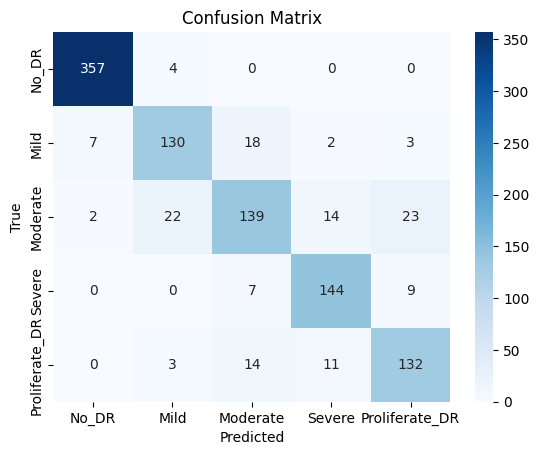

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_preds, target_names=Config.CLASS_NAMES))
conf_mat = confusion_matrix(y_true, y_preds)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=Config.CLASS_NAMES, yticklabels=Config.CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Macro AUC Score: 0.9743487709944955


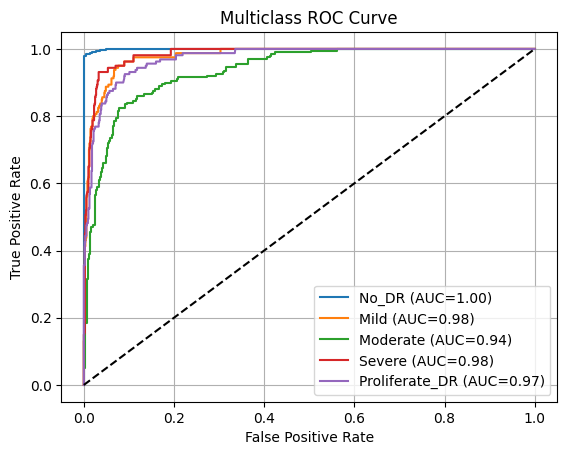

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize labels for multiclass AUC
y_true_bin = label_binarize(y_true, classes=np.arange(Config.NUM_CLASSES))

auc_score = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')
print("Macro AUC Score:", auc_score)

# Plot ROC curve per class
for i in range(Config.NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{Config.CLASS_NAMES[i]} (AUC={roc_auc_score(y_true_bin[:, i], y_probs[:, i]):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [7]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,458,183 (43.71 MB)

 Trainable params: 11,447,557 (43.67 MB)

 Non-trainable params: 10,624 (41.50 KB)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Mild


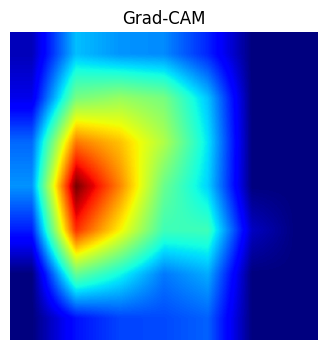

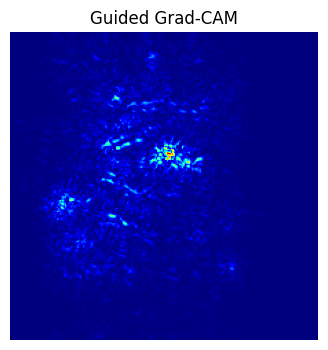

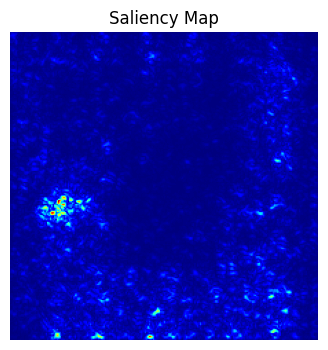

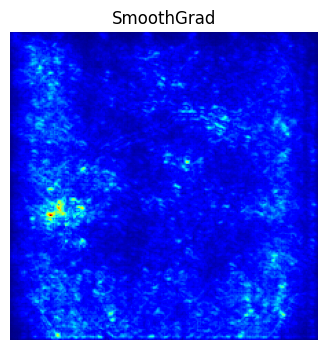

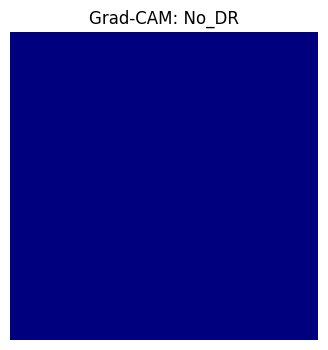

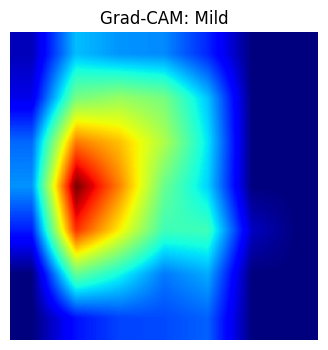

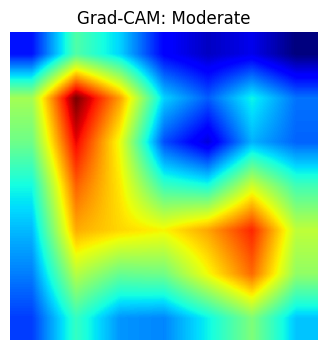

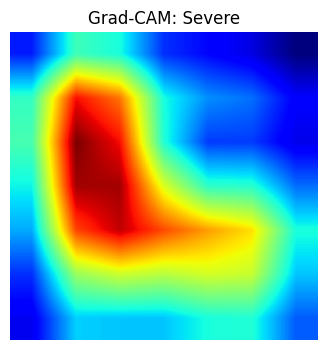

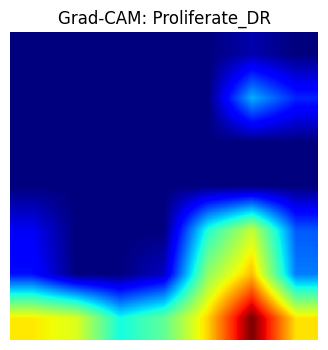

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# ==== CONFIG ====
IMG_SIZE = 224
MODEL_PATH = "/kaggle/working/dr_enhanced_best.h5"
CLASS_NAMES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
NUM_CLASSES = len(CLASS_NAMES)
LAYER_NAME = "conv2d_19"  # Change if needed

# ==== LOAD MODEL ====
model = load_model(MODEL_PATH, compile=False)

# ==== IMAGE PREPROCESSING ====
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return np.expand_dims(img, axis=0), img

# ==== VISUALIZATION ====
def show_map(map, title=""):
    plt.figure(figsize=(4, 4))
    plt.imshow(map, cmap='jet')
    plt.axis('off')
    plt.title(title)
    plt.show()

# ==== GRAD-CAM ====
def compute_gradcam(model, image_tensor, class_index, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_tensor)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return cv2.resize(heatmap.numpy(), (IMG_SIZE, IMG_SIZE))

# ==== GUIDED RELU ====
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
    return tf.nn.relu(x), grad

def modify_relu_for_guided(model):
    for layer in model.layers:
        if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu:
            layer.activation = guided_relu
    return model

# ==== GUIDED GRAD-CAM ====
def compute_guided_gradcam(model, image_tensor, class_index, layer_name):
    guided_model = modify_relu_for_guided(tf.keras.models.clone_model(model))
    guided_model.set_weights(model.get_weights())
    with tf.GradientTape() as tape:
        inputs = tf.cast(image_tensor, tf.float32)
        tape.watch(inputs)
        preds = guided_model(inputs)
        loss = preds[:, class_index]
    grads = tape.gradient(loss, inputs)[0].numpy()
    guided_grads = np.maximum(grads, 0)
    guided_grads -= guided_grads.min()
    guided_grads /= guided_grads.max() + 1e-8
    cam = compute_gradcam(model, image_tensor, class_index, layer_name)
    guided_gradcam = guided_grads * cam[..., np.newaxis]
    return guided_gradcam

# ==== SALIENCY ====
def compute_saliency(model, image_tensor, class_index):
    image_tensor = tf.convert_to_tensor(image_tensor, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        preds = model(image_tensor)
        loss = preds[:, class_index]
    grads = tape.gradient(loss, image_tensor)[0]
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() + 1e-8)
    return saliency

# ==== SMOOTHGRAD ====
def compute_smoothgrad(model, image_tensor, class_index, noise_level=0.1, samples=20):
    smoothgrad = np.zeros((IMG_SIZE, IMG_SIZE))
    for _ in range(samples):
        noise = noise_level * np.random.normal(size=image_tensor.shape)
        noisy_img = image_tensor + noise
        saliency = compute_saliency(model, noisy_img, class_index)
        smoothgrad += saliency
    return smoothgrad / samples

# ==== MAIN ====
img_path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0243404e8a00.png"  # CHANGE THIS
x, orig = preprocess_image(img_path)
pred = model.predict(x)
pred_class = np.argmax(pred)

print(f"Predicted Class: {CLASS_NAMES[pred_class]}")

# 1. Grad-CAM
cam = compute_gradcam(model, x, pred_class, LAYER_NAME)
show_map(cam, "Grad-CAM")

# 2. Guided Grad-CAM
ggcam = compute_guided_gradcam(model, x, pred_class, LAYER_NAME)
show_map(np.mean(ggcam, axis=-1), "Guided Grad-CAM")

# 3. Saliency
saliency = compute_saliency(model, x, pred_class)
show_map(saliency, "Saliency Map")

# 4. SmoothGrad
sgrad = compute_smoothgrad(model, x, pred_class)
show_map(sgrad, "SmoothGrad")

# 5. Per-Class Grad-CAMs
for i, cls in enumerate(CLASS_NAMES):
    cam = compute_gradcam(model, x, i, LAYER_NAME)
    show_map(cam, f"Grad-CAM: {cls}")


In [ ]:
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0 --quiet
import os
os.kill(os.getpid(), 9)  # Force restart the Kaggle kernel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 105.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 18.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
